Environment Setup

In [1]:
import franka_env
import torch as th
import numpy as np
import gymnasium as gym
from stable_baselines3 import SAC,DDPG,PPO,HerReplayBuffer
from stable_baselines3.common.noise import NormalActionNoise
from sb3_contrib.tqc import TQC
from torchviz import make_dot
from IPython.display import display
from franka_env import EpisodeInfoCallback

Push Training(PPO)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


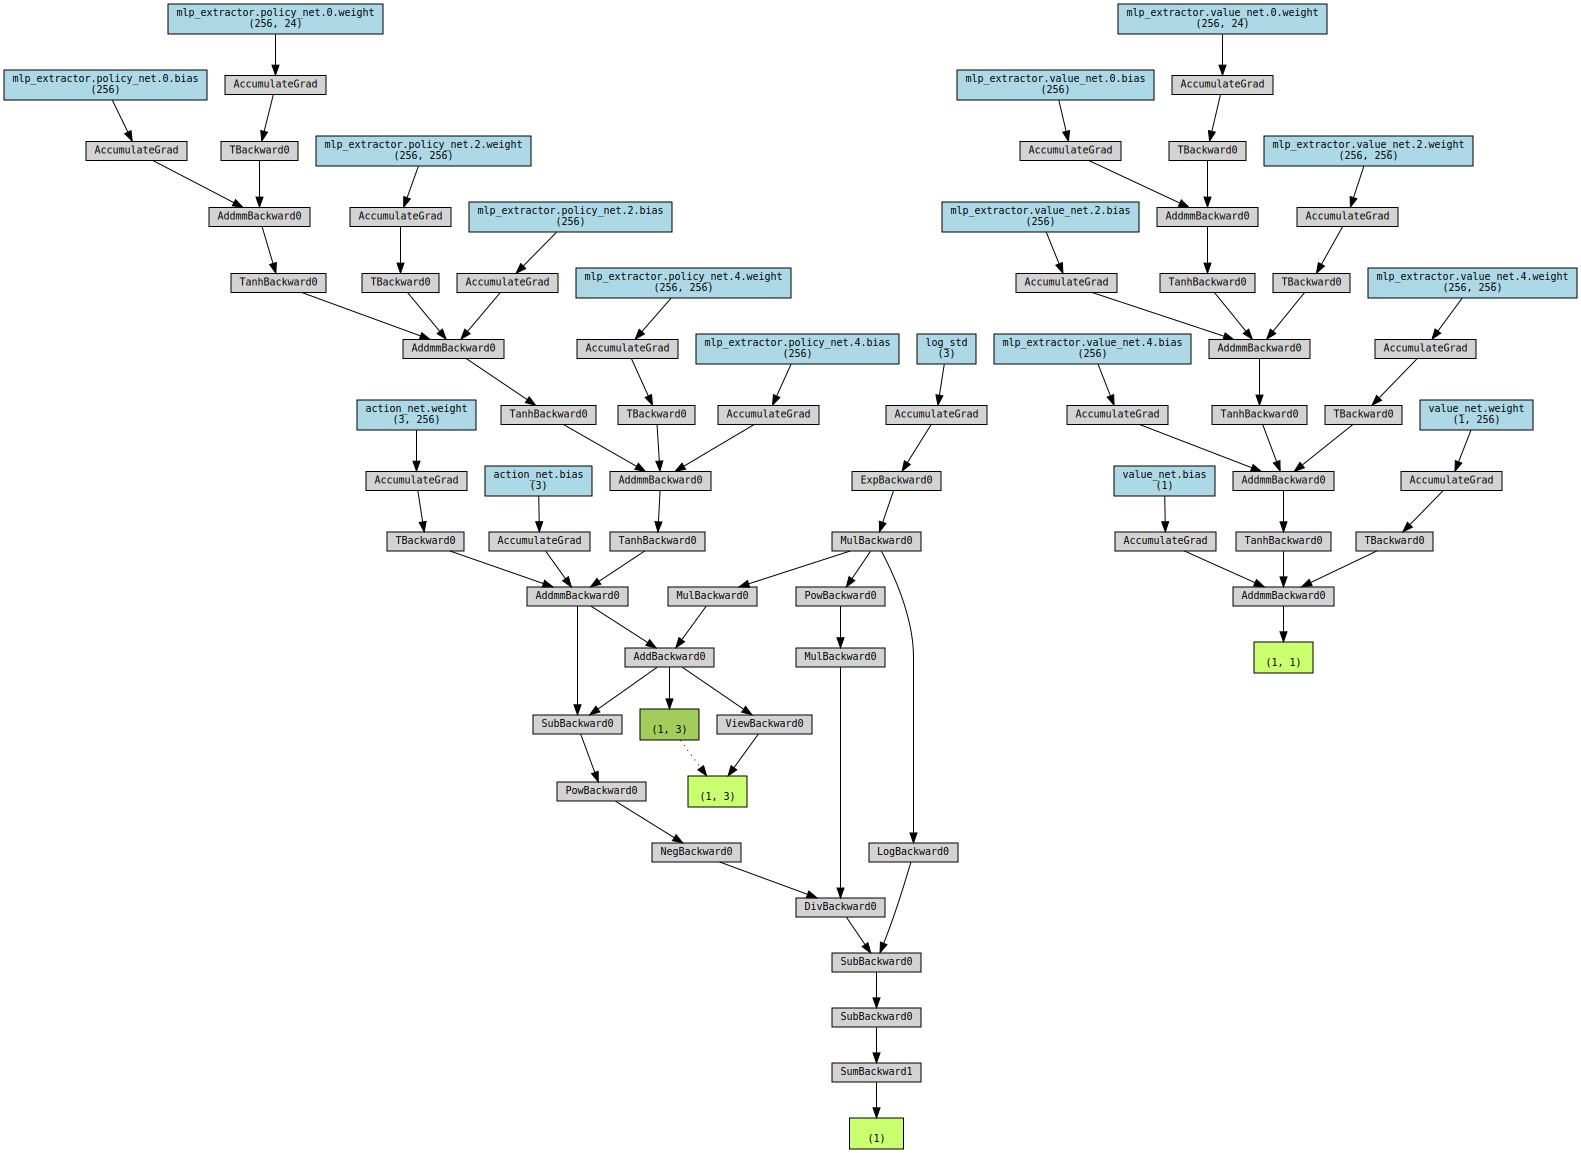

Logging to ./tensorboard/ppo_push/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 45.5     |
|    ep_rew_mean     | -45.5    |
|    success_rate    | 0.0909   |
| time/              |          |
|    fps             | 38       |
|    iterations      | 1        |
|    time_elapsed    | 53       |
|    total_timesteps | 2048     |
---------------------------------


In [2]:
env = gym.make("FrankaPushSparse", render_mode="human")

# Dimension of the action space
n_actions = env.action_space.shape[-1]

# Network architecture and optimizer parameters
policy_kwargs = dict(
    net_arch=[256, 256, 256],
    optimizer_class=th.optim.Adam,
)

# PPO agent
model = PPO(
    "MultiInputPolicy",
    env,
    policy_kwargs=policy_kwargs,
    learning_rate=0.001,
    batch_size=512,
    verbose=1,
    tensorboard_log="./tensorboard/ppo_push/",
)

# Visualize the network
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model.policy.to(device)
obs, _ = env.reset()
sample_input = {key: th.tensor(value).float().unsqueeze(0).to(device) for key, value in obs.items()}
output = model.policy(sample_input)
dot = make_dot(output, params=dict(model.policy.named_parameters()))
display(dot)

# Start training
model.learn(total_timesteps=200)
model.save('model/PPO_push.zip')

env.close()

Push Training(SAC)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


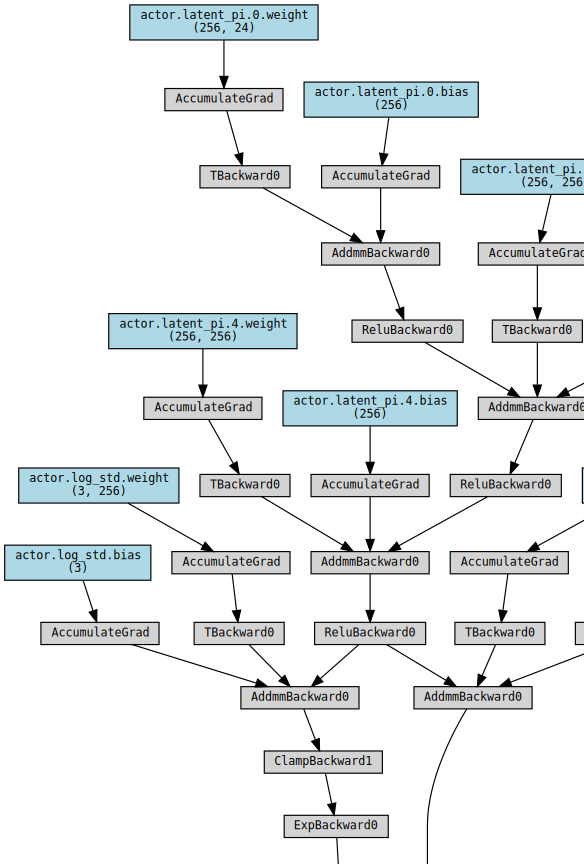

Logging to ./tensorboard/sac_push/SAC_1


/home/zachary/anaconda3/envs/rl_franka222/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.compute_reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.compute_reward` for environment variables or `env.get_wrapper_attr('compute_reward')` that will search the reminding wrappers.
  logger.warn(


Target Object Position: [0.61728751 0.14021622 0.01995554]
Initial Object Position: [ 0.47905237 -0.12686508  0.01995638]
Final Object Position: [0.74585746 0.14633083 0.01995554]
Distance between Object and Target:0.12872
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 39       |
|    time_elapsed    | 5        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -8.66    |
|    critic_loss     | 0.122    |
|    ent_coef        | 0.907    |
|    ent_coef_loss   | -0.494   |
|    learning_rate   | 0.001    |
|    n_updates       | 99       |
---------------------------------


In [3]:
env = gym.make("FrankaPushSparse", render_mode="human")

# Dimension of the action space
n_actions = env.action_space.shape[-1]

# Action noise
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.2 * np.ones(n_actions))

# Network architecture and optimizer parameters
policy_kwargs = dict(
    net_arch=[256, 256, 256],
    optimizer_class=th.optim.Adam,
)

# HER strategy
goal_selection_strategy = 'future'
n_sampled_goal = 4

# SAC agent
model = SAC(
    "MultiInputPolicy",
    env,
    policy_kwargs=policy_kwargs,
    action_noise=action_noise,
    replay_buffer_class=HerReplayBuffer,
    replay_buffer_kwargs=dict(
        n_sampled_goal=n_sampled_goal,
        goal_selection_strategy=goal_selection_strategy,
    ),
    learning_rate=0.001,
    batch_size=512,
    buffer_size=int(1e6),
    tau=0.05,
    gamma=0.95,
    verbose=1,
    tensorboard_log="./tensorboard/sac_push/", 
)

# Visualize the network
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model.policy.to(device)
obs, _ = env.reset()
sample_input = {key: th.tensor(value).float().unsqueeze(0).to(device) for key, value in obs.items()}
output = model.policy(sample_input)
dot = make_dot(output, params=dict(model.policy.named_parameters()))
display(dot)

# Start training
callback = EpisodeInfoCallback(env)
model.learn(total_timesteps=200, callback=callback)
model.save('model/SAC_push.zip')

env.close()

Push Training(DDPG)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


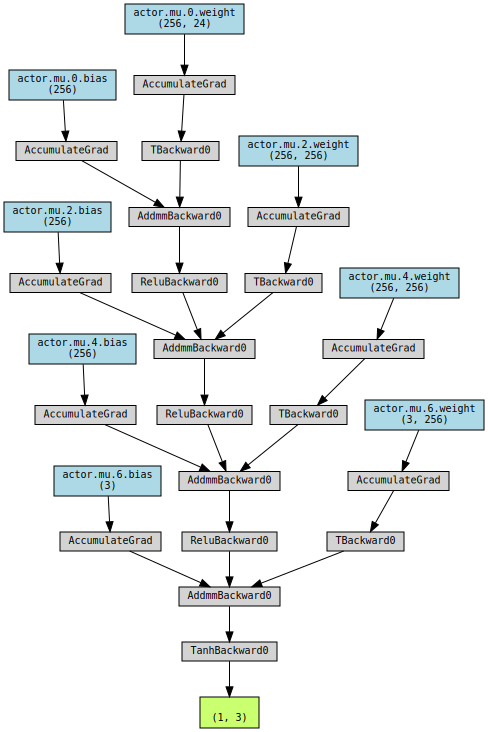

Logging to ./tensorboard/ddpg_push/DDPG_1


/home/zachary/anaconda3/envs/rl_franka222/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.compute_reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.compute_reward` for environment variables or `env.get_wrapper_attr('compute_reward')` that will search the reminding wrappers.
  logger.warn(


Target Object Position: [0.74999439 0.00906308 0.01995554]
Initial Object Position: [ 0.71532068 -0.08551185  0.01995638]
Final Object Position: [ 0.67713551 -0.02127342  0.01995554]
Distance between Object and Target:0.07892
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 39       |
|    time_elapsed    | 5        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | 0.807    |
|    critic_loss     | 0.101    |
|    learning_rate   | 0.001    |
|    n_updates       | 99       |
---------------------------------


In [4]:
env = gym.make("FrankaPushSparse", render_mode="human")

# Dimension of the action space
n_actions = env.action_space.shape[-1]

# Action noise
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.2 * np.ones(n_actions))

# Network architecture and optimizer parameters
policy_kwargs = dict(
    net_arch=[256, 256, 256],
    optimizer_class=th.optim.Adam,
)

# HER strategy
goal_selection_strategy = 'future'
n_sampled_goal = 4

# DDPG agent
model = DDPG(
    "MultiInputPolicy",
    env,
    policy_kwargs=policy_kwargs,
    action_noise=action_noise,
    replay_buffer_class=HerReplayBuffer,
    replay_buffer_kwargs=dict(
        n_sampled_goal=n_sampled_goal,
        goal_selection_strategy=goal_selection_strategy,
    ),
    learning_rate=0.001,
    batch_size=512,
    buffer_size=int(1e6), 
    tau=0.05,
    gamma=0.95,
    verbose=1,
    tensorboard_log="./tensorboard/ddpg_push/",
)

# Visualize the network
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model.policy.to(device)
obs, _ = env.reset()
sample_input = {key: th.tensor(value).float().unsqueeze(0).to(device) for key, value in obs.items()}
output = model.policy(sample_input)
dot = make_dot(output, params=dict(model.policy.named_parameters()))
display(dot)

# Start training
callback = EpisodeInfoCallback(env)
model.learn(total_timesteps=200, callback=callback)
model.save('model/DDPG_push.zip')

env.close()

Push Training(TQC)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


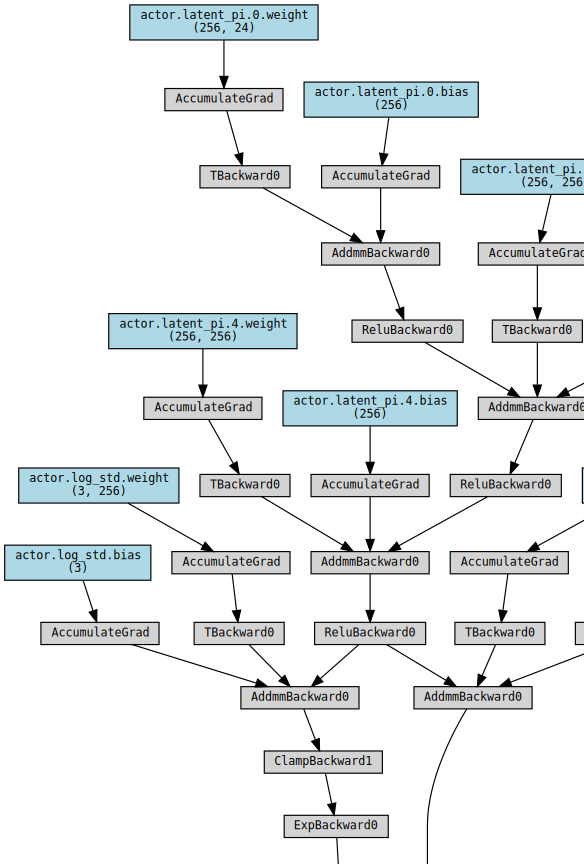

Logging to ./tensorboard/tqc_push/TQC_1


/home/zachary/anaconda3/envs/rl_franka222/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.compute_reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.compute_reward` for environment variables or `env.get_wrapper_attr('compute_reward')` that will search the reminding wrappers.
  logger.warn(


Target Object Position: [ 0.73233504 -0.0626085   0.01995554]
Initial Object Position: [0.72070223 0.1174878  0.01995638]
Final Object Position: [0.49408602 0.03972937 0.01995554]
Distance between Object and Target:0.25930
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 39       |
|    time_elapsed    | 5        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -7.95    |
|    critic_loss     | 0.05     |
|    ent_coef        | 0.907    |
|    ent_coef_loss   | -0.495   |
|    learning_rate   | 0.001    |
|    n_updates       | 99       |
---------------------------------


In [5]:
env = gym.make("FrankaPushSparse", render_mode="human")

# Dimension of the action space
n_actions = env.action_space.shape[-1]

# Action noise
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.2 * np.ones(n_actions))

# Network architecture and optimizer parameters
policy_kwargs = dict(
    net_arch=[256, 256, 256],
    optimizer_class=th.optim.Adam,
    n_critics=2,
    n_quantiles=25,
)

# HER strategy
goal_selection_strategy = 'future'
n_sampled_goal = 4

# TQC agent
model = TQC(
    "MultiInputPolicy",
    env,
    policy_kwargs=policy_kwargs,
    action_noise=action_noise,
    replay_buffer_class=HerReplayBuffer,
    replay_buffer_kwargs=dict(
        n_sampled_goal=n_sampled_goal,
        goal_selection_strategy=goal_selection_strategy,
    ),
    learning_rate=0.001,
    batch_size=512,
    buffer_size=int(1e6),
    tau=0.05,
    gamma=0.95,
    verbose=1,
    tensorboard_log="./tensorboard/tqc_push/",
    
)

# Visualize the network
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model.policy.to(device)
obs, _ = env.reset()
sample_input = {key: th.tensor(value).float().unsqueeze(0).to(device) for key, value in obs.items()}
output = model.policy(sample_input)
dot = make_dot(output, params=dict(model.policy.named_parameters()))
display(dot)

# Start training
callback = EpisodeInfoCallback(env)
model.learn(total_timesteps=200, callback=callback)
model.save('model/TQC_push.zip')

env.close()

Pick Training(PPO)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


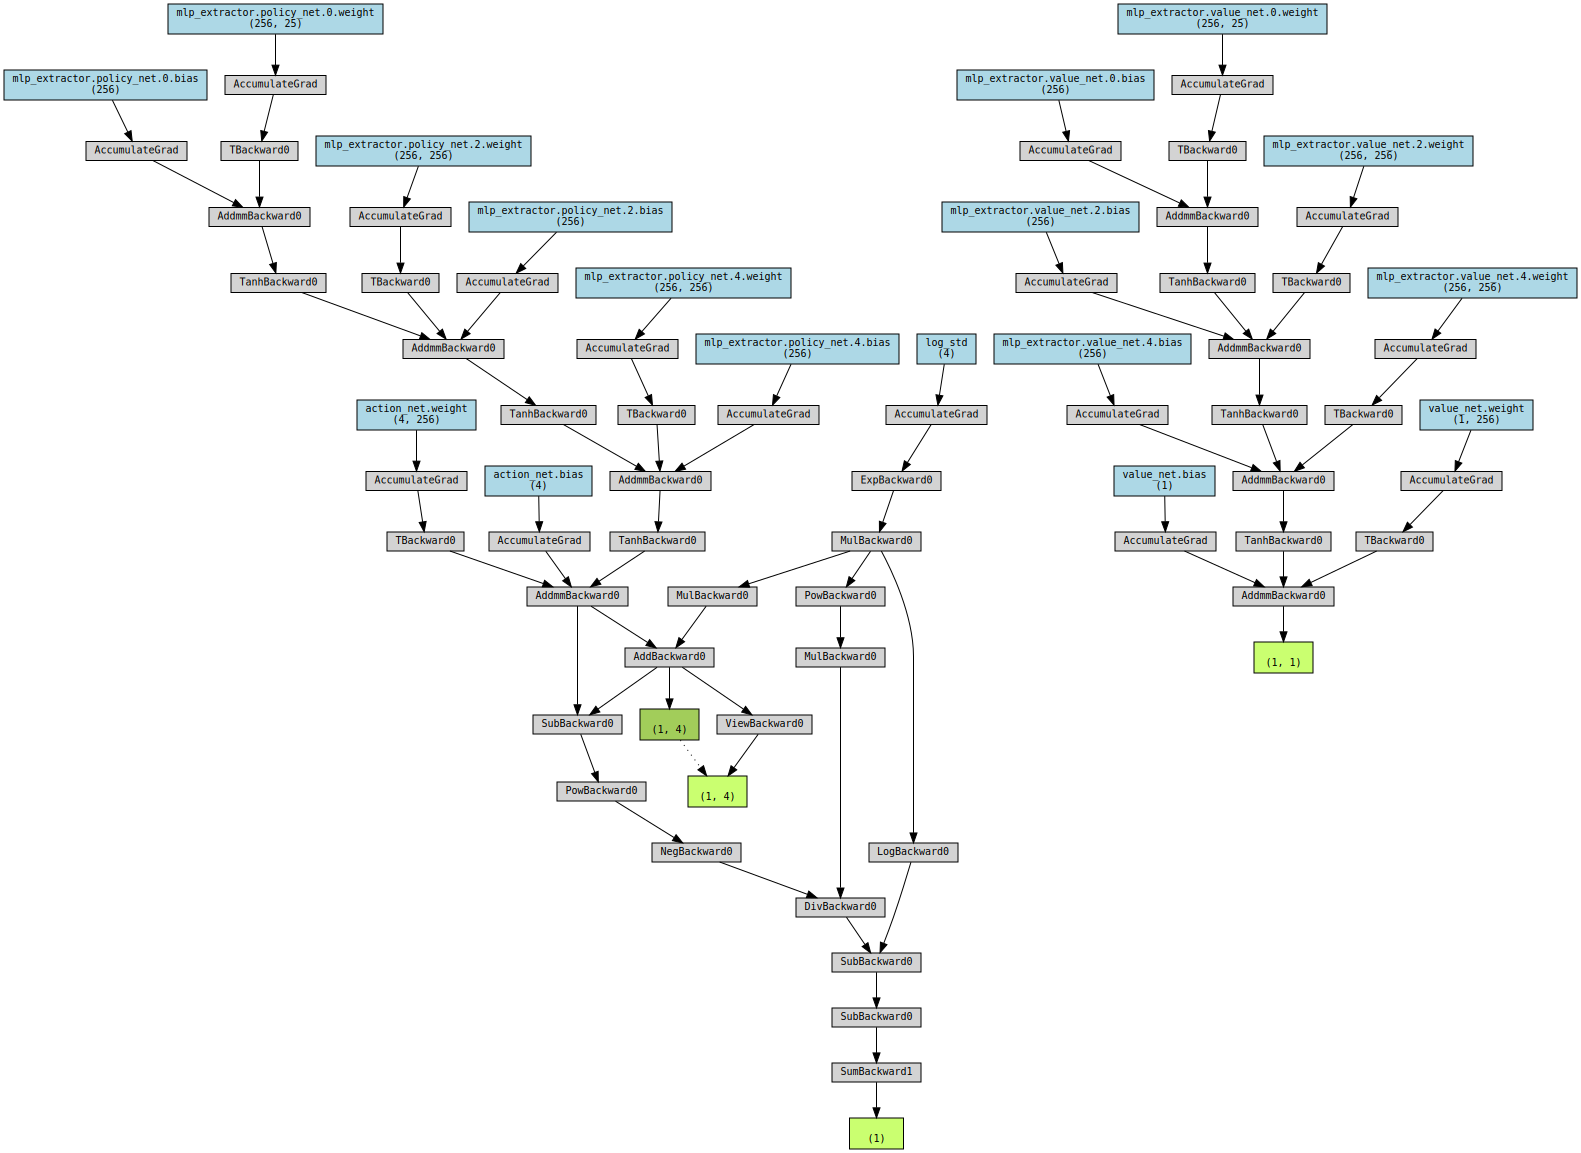

Logging to ./tensorboard/ppo_pick/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 49.8     |
|    ep_rew_mean     | -49.8    |
|    success_rate    | 0.0244   |
| time/              |          |
|    fps             | 39       |
|    iterations      | 1        |
|    time_elapsed    | 52       |
|    total_timesteps | 2048     |
---------------------------------


In [6]:
env = gym.make("FrankaPickSparse", render_mode="human")

# Dimension of the action space
n_actions = env.action_space.shape[-1]

# Network architecture and optimizer parameters
policy_kwargs = dict(
    net_arch=[256, 256, 256],
    optimizer_class=th.optim.Adam,
)

# PPO agent
model = PPO(
    "MultiInputPolicy",
    env,
    policy_kwargs=policy_kwargs,
    learning_rate=0.001,
    batch_size=512,
    verbose=1,
    tensorboard_log="./tensorboard/ppo_pick/",
)

# Visualize the network
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model.policy.to(device)
obs, _ = env.reset()
sample_input = {key: th.tensor(value).float().unsqueeze(0).to(device) for key, value in obs.items()}
output = model.policy(sample_input)
dot = make_dot(output, params=dict(model.policy.named_parameters()))
display(dot)

# Start training
model.learn(total_timesteps=200)
model.save('model/PPO_pick.zip')

env.close()

Pick Training(SAC)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


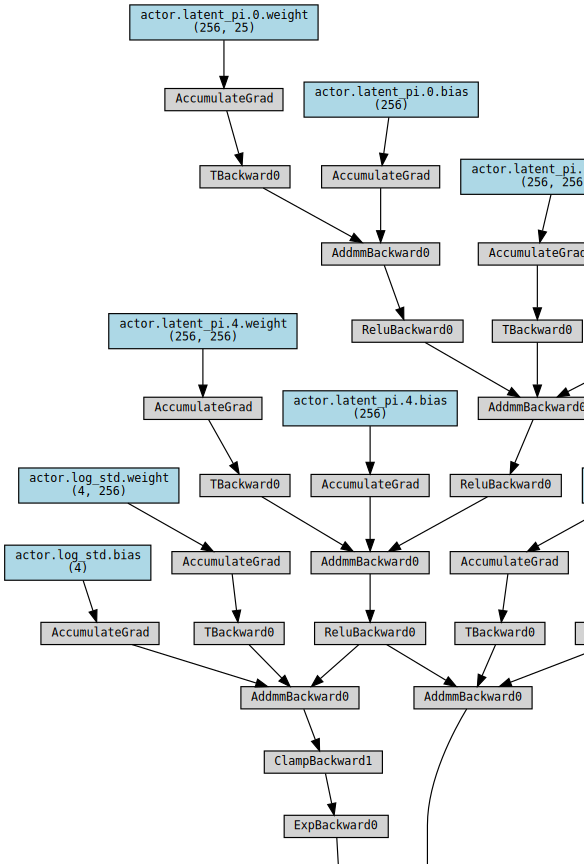

Logging to ./tensorboard/sac_pick/SAC_1


/home/zachary/anaconda3/envs/rl_franka222/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.compute_reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.compute_reward` for environment variables or `env.get_wrapper_attr('compute_reward')` that will search the reminding wrappers.
  logger.warn(


Target Object Position: [ 0.73701943 -0.00770943  0.15008195]
Initial Object Position: [0.71431088 0.00376226 0.01995638]
Final Object Position: [0.7199436  0.05120293 0.01995558]
Distance between Object and Target:0.14386
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 39       |
|    time_elapsed    | 5        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -12      |
|    critic_loss     | 0.177    |
|    ent_coef        | 0.907    |
|    ent_coef_loss   | -0.658   |
|    learning_rate   | 0.001    |
|    n_updates       | 99       |
---------------------------------


In [7]:
env = gym.make("FrankaPickSparse", render_mode="human")

# Dimension of the action space
n_actions = env.action_space.shape[-1]

# Action noise
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.2 * np.ones(n_actions))

# Network architecture and optimizer parameters
policy_kwargs = dict(
    net_arch=[256, 256, 256],
    optimizer_class=th.optim.Adam,
)

# HER strategy
goal_selection_strategy = 'future'
n_sampled_goal = 4

# SAC agent
model = SAC(
    "MultiInputPolicy",
    env,
    policy_kwargs=policy_kwargs,
    action_noise=action_noise,
    replay_buffer_class=HerReplayBuffer,
    replay_buffer_kwargs=dict(
        n_sampled_goal=n_sampled_goal,
        goal_selection_strategy=goal_selection_strategy,
    ),
    learning_rate=0.001,
    batch_size=512,
    buffer_size=int(1e6),
    tau=0.05,
    gamma=0.95,
    verbose=1,
    tensorboard_log="./tensorboard/sac_pick/",
)

# Visualize the network
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model.policy.to(device)
obs, _ = env.reset()
sample_input = {key: th.tensor(value).float().unsqueeze(0).to(device) for key, value in obs.items()}
output = model.policy(sample_input)
dot = make_dot(output, params=dict(model.policy.named_parameters()))
display(dot)

# Start training
callback = EpisodeInfoCallback(env)
model.learn(total_timesteps=200, callback=callback)
model.save('model/SAC_pick.zip')

env.close()

Pick Training(DDPG)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


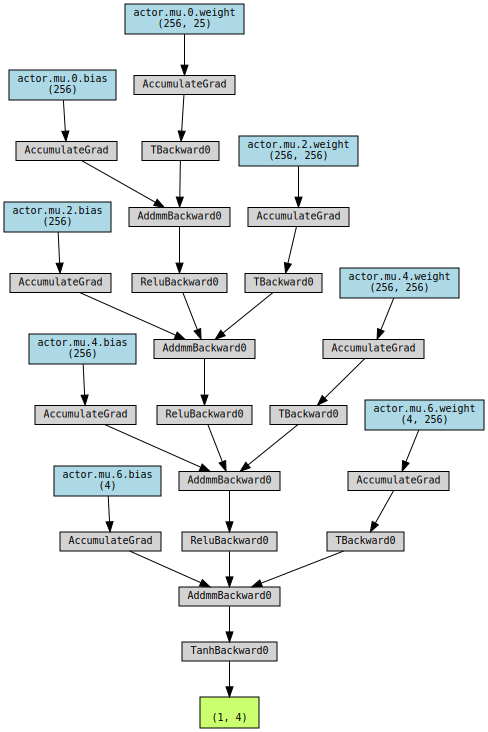

Logging to ./tensorboard/ddpg_pick/DDPG_1


/home/zachary/anaconda3/envs/rl_franka222/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.compute_reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.compute_reward` for environment variables or `env.get_wrapper_attr('compute_reward')` that will search the reminding wrappers.
  logger.warn(


Target Object Position: [0.66776524 0.10989283 0.01995558]
Initial Object Position: [ 0.48511708 -0.07922646  0.01995638]
Final Object Position: [0.47451017 0.02828716 0.01995558]
Distance between Object and Target:0.20978
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 39       |
|    time_elapsed    | 5        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | 0.583    |
|    critic_loss     | 0.0455   |
|    learning_rate   | 0.001    |
|    n_updates       | 99       |
---------------------------------


In [8]:
env = gym.make("FrankaPickSparse", render_mode="human")

# Dimension of the action space
n_actions = env.action_space.shape[-1]

# Action noise
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.2 * np.ones(n_actions))

# Network architecture and optimizer parameters
policy_kwargs = dict(
    net_arch=[256, 256, 256],
    optimizer_class=th.optim.Adam,
)

# HER strategy
goal_selection_strategy = 'future'
n_sampled_goal = 4

# DDPG agent
model = DDPG(
    "MultiInputPolicy",
    env,
    policy_kwargs=policy_kwargs,
    action_noise=action_noise,
    replay_buffer_class=HerReplayBuffer,
    replay_buffer_kwargs=dict(
        n_sampled_goal=n_sampled_goal,
        goal_selection_strategy=goal_selection_strategy,
    ),
    learning_rate=0.001,
    batch_size=512,
    buffer_size=int(1e6), 
    tau=0.05,
    gamma=0.95,
    verbose=1,
    tensorboard_log="./tensorboard/ddpg_pick/",
)

# Visualize the network
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model.policy.to(device)
obs, _ = env.reset()
sample_input = {key: th.tensor(value).float().unsqueeze(0).to(device) for key, value in obs.items()}
output = model.policy(sample_input)
dot = make_dot(output, params=dict(model.policy.named_parameters()))
display(dot)

# Start training
callback = EpisodeInfoCallback(env)
model.learn(total_timesteps=200, callback=callback)
model.save('model/DDPG_pick.zip')

env.close()

Pick Training(TQC)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


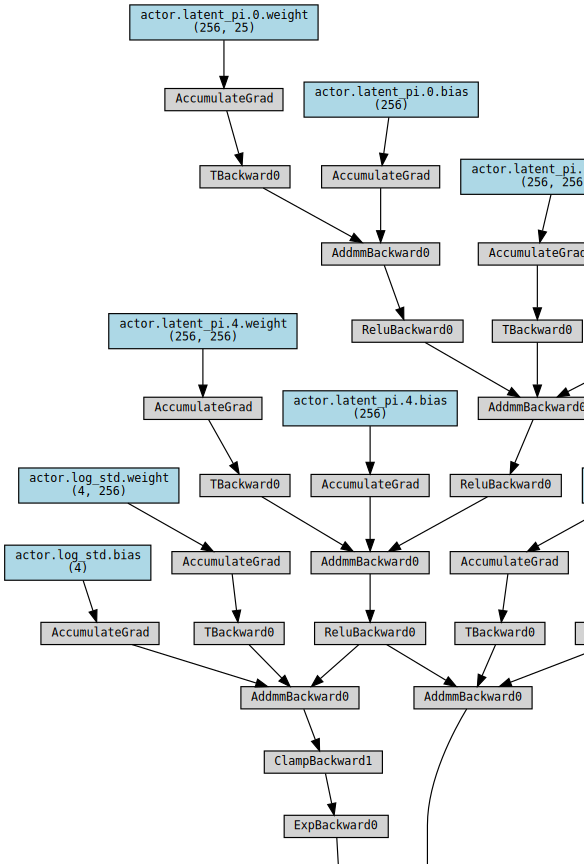

Logging to ./tensorboard/tqc_pick/TQC_1


/home/zachary/anaconda3/envs/rl_franka222/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.compute_reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.compute_reward` for environment variables or `env.get_wrapper_attr('compute_reward')` that will search the reminding wrappers.
  logger.warn(


Target Object Position: [0.62472948 0.07475575 0.10970168]
Initial Object Position: [0.48688001 0.10211101 0.01995638]
Final Object Position: [0.50679942 0.02892944 0.01995558]
Distance between Object and Target:0.15512
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 39       |
|    time_elapsed    | 5        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -10.8    |
|    critic_loss     | 0.0533   |
|    ent_coef        | 0.907    |
|    ent_coef_loss   | -0.662   |
|    learning_rate   | 0.001    |
|    n_updates       | 99       |
---------------------------------


In [9]:
env = gym.make("FrankaPickSparse", render_mode="human")

# Dimension of the action space
n_actions = env.action_space.shape[-1]

# Action noise
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.2 * np.ones(n_actions))

# Network architecture and optimizer parameters
policy_kwargs = dict(
    net_arch=[256, 256, 256],
    optimizer_class=th.optim.Adam,
    n_critics=2,
    n_quantiles=25,
)

# HER strategy
goal_selection_strategy = 'future'
n_sampled_goal = 4

# TQC agent
model = TQC(
    "MultiInputPolicy",
    env,
    policy_kwargs=policy_kwargs,
    action_noise=action_noise,
    replay_buffer_class=HerReplayBuffer,
    replay_buffer_kwargs=dict(
        n_sampled_goal=n_sampled_goal,
        goal_selection_strategy=goal_selection_strategy,
    ),
    learning_rate=0.001,
    batch_size=512,
    buffer_size=int(1e6),
    tau=0.05,
    gamma=0.95,
    verbose=1,
    tensorboard_log="./tensorboard/tqc_pick/",
)

# Visualize the network
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model.policy.to(device)
obs, _ = env.reset()
sample_input = {key: th.tensor(value).float().unsqueeze(0).to(device) for key, value in obs.items()}
output = model.policy(sample_input)
dot = make_dot(output, params=dict(model.policy.named_parameters()))
display(dot)

# Start training
callback = EpisodeInfoCallback(env)
model.learn(total_timesteps=200, callback=callback)
model.save('model/TQC_pick.zip')

env.close()